In [1]:
# Install required packages
!apt install tesseract-ocr
!pip install pytesseract opencv-python-headless matplotlib


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Configure pytesseract path (Colab already has it after install)
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


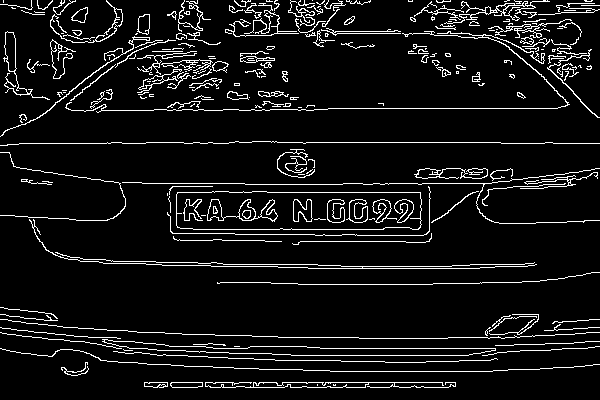

In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
# Load the image
img = cv2.imread('/content/carnum.jpeg')
img = cv2.resize(img, (600, 400))  # Resize for better visibility

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Noise removal
blur = cv2.bilateralFilter(gray, 11, 17, 17)

# Edge detection
edged = cv2.Canny(blur, 30, 200)

cv2_imshow(edged)


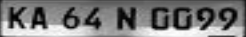

In [ ]:
# Find contours
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort and look for rectangular contour
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    if len(approx) == 4:
        screenCnt = approx
        break

if screenCnt is None:
    print("No contour detected.")
else:
    # Mask everything except plate
    mask = cv2.drawContours(np.zeros(gray.shape, dtype=np.uint8), [screenCnt], 0, 255, -1)
    out = cv2.bitwise_and(img, img, mask=mask)

    # Crop the plate
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    cropped = gray[topx:bottomx+1, topy:bottomy+1]

    cv2_imshow(cropped)


In [ ]:
# Enhance cropped image
cropped = cv2.resize(cropped, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
_, thresh = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# OCR
text = pytesseract.image_to_string(thresh, config='--psm 7 -l eng')
print("Detected Number Plate:", text.strip())


Detected Number Plate: VK i ay F ‘wor
